# Sound Classification with CNN and Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [3]:
import os
import librosa
import librosa.display
import glob 
import skimage

In [4]:
metadata = pd.read_csv('C:/Users/user/PycharmProjects/pythonProject/CatSound/metadata/cat2.csv')
print(metadata.shape)
metadata.head()

(1120, 4)


,slice_file_name,fold,classID,class
0,purring (1).wav,1,0,purring
1,purring (2).wav,1,0,purring
2,purring (3).wav,1,0,purring
3,purring (4).wav,1,0,purring
4,purring (5).wav,1,0,purring


In [5]:
classes = metadata.groupby('classID')['class'].unique()
classes

classID
0     [purring]
1        [meow]
2    [grooming]
3    [drinking]
4          [wc]
5      [eating]
Name: class, dtype: object

In [6]:
def feature_extractor(path):
    data, simple_rate = librosa.load(path)
    data = librosa.feature.mfcc(data,n_mfcc=128)
    data = np.mean(data,axis=1)
    return data

In [ ]:
#feature extraction with mfcc
x, y = [], []
extracted_features=[]
for i,rows in tqdm(metadata.iterrows()):
    path = 'C:/Users/user/PycharmProjects/pythonProject/CatSound/audio/' + 'fold' + str(rows['fold']) + '/' + str(rows['slice_file_name'])
    x.append(feature_extractor(path))
    y.append(rows['classID'])
    fe = feature_extractor(path)
    final_class_labels=rows['class']
    extracted_features.append([fe,final_class_labels])
x = np.array(x)
y = np.array(y)
x.shape, y.shape

In [8]:
#each audio has mfcc matrix
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-312.18478, 125.071014, -64.47501, 56.468628,...",purring
1,"[-408.58997, 146.62447, 32.391697, 36.671593, ...",purring
2,"[-440.81326, 190.86948, -21.095238, -6.7931995...",purring
3,"[-373.53268, 150.26164, 44.241188, 31.615002, ...",purring
4,"[-578.2753, 163.7805, 61.469208, 17.083605, -3...",purring


In [9]:
y = to_categorical(y)
y.shape

(1120, 6)

In [10]:
xtrainval, xtest, ytrainval, ytest = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])


Number of samples for Train set : 806
Number of samples for Validation set : 202
Number of samples for Test set : 112


In [11]:
xtrain = xtrain.reshape(806, 16, 8, 1)
xtest = xtest.reshape(112, 16, 8, 1)
xvalid = xvalid.reshape(202, 16, 8, 1)

In [12]:
input_dim = (16, 8, 1)

In [14]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner
import tensorflow as tf

In [15]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = Sequential() # tuning: number of hidden layers, number of neurons, dropout rate, activation function
    
    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3), padding = "same", activation = hp.Choice("activation", ["relu", "tanh"]), input_shape = input_dim))
    model.add(MaxPool2D(pool_size=(2, 2)))
    for i in range(hp.Int('n_layers', 1, 4)):  
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3), padding = "same", activation = hp.Choice("activation", ["relu", "tanh"])))
    model.add(Dropout(rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05)))
    model.add(Flatten())
    model.add(Dense(1024, activation = hp.Choice("activation", ["relu", "tanh"])))
    model.add(Dense(6, activation = "softmax"))
    
    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
checkpointer = ModelCheckpoint(filepath='saved_models/cat_model_1.hdf5', 
                               verbose=1, save_best_only=True)

In [18]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # how many model variations to test?
    executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
    overwrite=True)

In [19]:
tuner.search(x=xtrain,
             y=ytrain,
             verbose=10, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=50,
             batch_size=20,
             validation_data=(xvalid, yvalid)
             )

Trial 5 Complete [00h 00m 57s]
val_accuracy: 0.9966996510823568

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 12m 39s
INFO:tensorflow:Oracle triggered exit


In [20]:
best_hp=tuner.get_best_hyperparameters()[0]

In [21]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
history=h_model.fit(xtrain, ytrain, epochs=50, validation_split=0.2, callbacks=[checkpointer])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 8, 224)        2240      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 4, 224)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 4, 224)         451808    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 4, 224)         451808    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 4, 224)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

21/21 [==============================] - 0s 11ms/step - loss: 3.3782e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000

Epoch 00032: val_loss improved from 0.00298 to 0.00298, saving model to saved_models\cat_model_1.hdf5
Epoch 33/50
21/21 [==============================] - 0s 9ms/step - loss: 3.2303e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000

Epoch 00033: val_loss improved from 0.00298 to 0.00287, saving model to saved_models\cat_model_1.hdf5
Epoch 34/50
21/21 [==============================] - 0s 9ms/step - loss: 3.0886e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000

Epoch 00034: val_loss improved from 0.00287 to 0.00281, saving model to saved_models\cat_model_1.hdf5
Epoch 35/50
21/21 [==============================] - 0s 10ms/step - loss: 2.9850e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000

Epoch 00035: val_loss did not improve from 0.00281
Epoch 36/50
21/21 [==============================] - 0s 9ms/step - lo

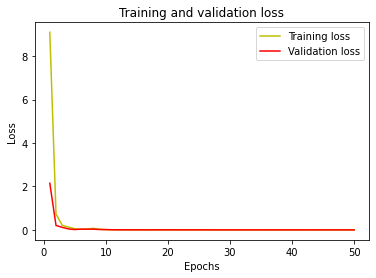

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

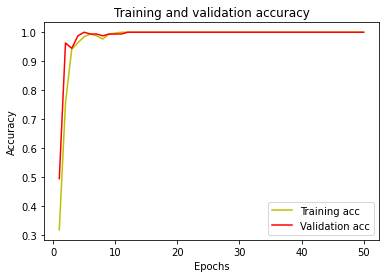

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
train_hist = pd.DataFrame(history.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,9.104908,0.316770,2.152408,0.493827
1,0.739106,0.756211,0.205756,0.962963
2,0.210362,0.940994,0.117513,0.944444
3,0.128881,0.964286,0.047211,0.987654
4,0.056407,0.984472,0.016594,1.000000
5,0.031146,0.993789,0.035747,0.993827
6,0.041192,0.987578,0.034469,0.993827
7,0.071865,0.976708,0.035266,0.987654
8,0.033629,0.993789,0.018728,0.993827
9,0.010373,0.996894,0.015937,0.993827


In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
#Confusion matrix to calculate accuracy for each class
ytrue = np.argmax(ytest,axis=1)
ypred = np.argmax(h_model.predict(xtest),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[19  1  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 20]]


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        20

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112



In [27]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 224,
 'activation': 'tanh',
 'n_layers': 2,
 'conv_0_units': 224,
 'dropout': 0.05,
 'conv_1_units': 224,
 'conv_2_units': 128}

In [28]:
# evaluate the model
_, train_acc = h_model.evaluate(xtrain, ytrain, verbose=0)
_, test_acc = h_model.evaluate(xtest, ytest, verbose=0)

In [29]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1.000, Test: 0.991


In [30]:
predictions = h_model.predict(xtest)
score = h_model.evaluate(xtest, ytest)
print(score)

4/4 [==============================] - 0s 18ms/step - loss: 0.0114 - accuracy: 0.9911
[0.011419768445193768, 0.9910714030265808]
